# Assignment 4: Tracking, Time-resolved microscopy

In [176]:
import diplib as dip
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import string
from tqdm import trange

In [187]:
matplotlib.rc('font',family='STIXGeneral', size=15)

## Global parameters

In [3]:
img_folder = 'images/'
fn_pattern = 'MTLn3{group}00{num}.tif'
group_names = {'egf': '+egf', 'ctrl': '-ctrl'}

initial_coords = [[413, 150], [80, 221], [80, 249], [336, 254], [80, 327],
                  [334,  85], [103, 122], [325, 155], [416, 426], [168, 116],
                  [422, 359], [194, 378], [391, 396], [206, 419], [100, 421]]
initial_coords = np.array(initial_coords)

## Functions' definitions

In [4]:
def remove_border_objects(img):
    seed = np.ones(np.array(img.Sizes()) - 2)
    seed = 1 - np.pad(seed, pad_width=1)
    seed = dip.FixedThreshold(dip.Image(seed), 0.5)
    edge_objects = dip.BinaryPropagation(seed, img)
    img -= edge_objects
    return img

def calculate_difference(cell1, cell2):
    distance = (cell1['x_coord'] - cell2['x_coord']) ** 2
    distance += (cell1['y_coord'] - cell2['y_coord']) ** 2
    size_difference = np.abs(cell1['size'] - cell2['size'])
    return np.sqrt(distance) + size_difference

def track_cell(images, segmented, initial_coords, size=200, displacement_tolerance=10):
    x_coords, y_coords, sizes = [], [], []
    labeled_archive = []
    x_coords.append(initial_coords[0])
    y_coords.append(initial_coords[1])
    current_cell = {'size': size, 'x_coord': initial_coords[0], 'y_coord': initial_coords[0]}
    for i in range(30):
        x, y = x_coords[-1], y_coords[-1]
        iter_counter = 0
        found_candidates = 0
        offset = displacement_tolerance
        while found_candidates < 1 and iter_counter < 5:
            iter_counter += 1
            offset *= 2 ** iter_counter
            seed = np.zeros(images[0].Sizes())
            seed[x-offset: x+offset, y-offset: y+offset] = 1
            seed = dip.FixedThreshold(seed, 0.5)
            masked = dip.BinaryPropagation(seed, segmented[i])
            labeled = dip.Label(masked, connectivity=1)
            msr = dip.MeasurementTool.Measure(labeled, images[0], ['Gravity', 'Size'])
            chosen_candidate = 1
            found_candidates = msr.NumberOfObjects()
            if found_candidates > 1:
                differences = [calculate_difference({'size': msr['Size'][j+1][0], 'x_coord': msr['Gravity'][j+1][1], 'y_coord': msr['Gravity'][j+1][0]},
                                                    current_cell) for j in range(msr.NumberOfObjects())]
                chosen_candidate = np.argmin(differences) + 1
    
        if found_candidates < 1:
            return labeled_archive, x_coords, y_coords, sizes # did not find the cell in the given window

        y_coord, x_coord = msr['Gravity'][chosen_candidate]
        size = msr['Size'][chosen_candidate][0]
        
        labeled_archive.append(labeled)
        x_coords.append(int(x_coord))
        y_coords.append(int(y_coord))
        sizes.append(size)
        current_cell = {'size': sizes[-1], 'x_coord': x_coords[-1], 'y_coord': y_coords[-1]}
    return labeled_archive, x_coords, y_coords, sizes

## Data loading and segmentation

In [5]:
images = {'ctrl': {}, 'egf': {}}
for group in images.keys():
    for num in range(30):
        num_str = '0' + str(num) if num < 10 else str(num)
        img = dip.ImageReadTIFF(img_folder + fn_pattern.format(group=group_names[group], num=num_str))
        rescaled_img = img / 2 ** 16 # rescale to [0..1]
        grey_img = dip.ColorSpaceManager.Convert(rescaled_img, 'grey') # convert from RGB to grey-scale
        images[group][num] = grey_img

segmented = {}
for num in images['ctrl'].keys():
    img = images['ctrl'][num]
    bin_img = dip.IsodataThreshold(img) # apply ISODATA threshold
    noe_img = remove_border_objects(bin_img)
    segmented[num] = noe_img

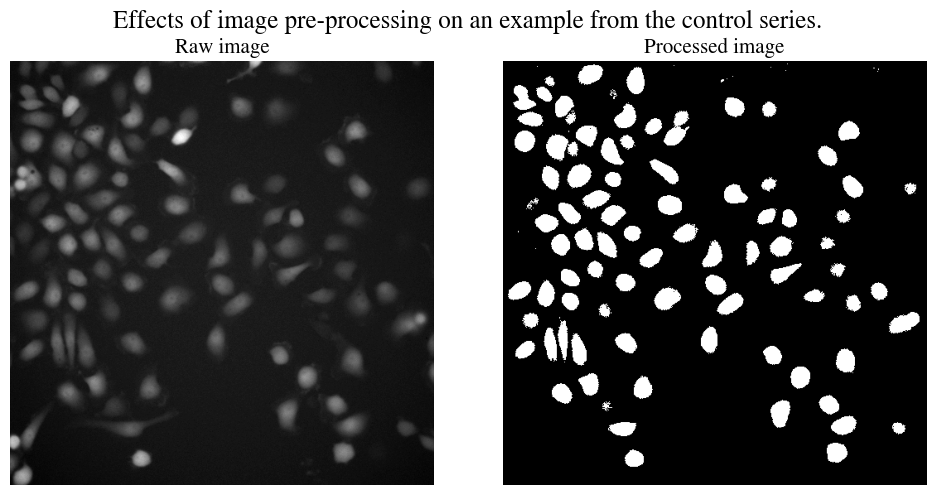

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
img = dip.ImageReadTIFF('images/MTLn3-ctrl0000.tif')
img = img / 2 ** 16
axs[0].imshow(img, origin='lower', cmap='grey')
axs[0].set_title('Raw image', fontname='STIXGeneral', fontsize=15)
axs[1].imshow(segmented[0], origin='lower', cmap='grey')
axs[1].set_title('Processed image', fontname='STIXGeneral', fontsize=15)
[axs[i].axis('off') for i in range(len(axs))]
fig.suptitle('Effects of image pre-processing on an example from the control series.', fontname='STIXGeneral', fontsize=18)
plt.tight_layout()
plt.savefig('figures/preprocessing.png')

## Computing Accumulative Difference Images (ADIs)

In [7]:
R = images['ctrl'][0]
adi_pos = np.zeros((512, 512))
adi_neg = np.zeros((512, 512))

for i in range(30):
    grad = images['ctrl'][i] - R
    grad_pos, grad_neg = np.copy(grad), np.copy(grad)
    grad_pos[grad_pos > 0.01] = 1
    grad_pos[grad_pos <= 0.01] = 0
    grad_neg[grad_neg >= -0.01] = 0
    grad_neg[grad_neg < -0.01] = 1
    adi_pos += grad_pos
    adi_neg += grad_neg

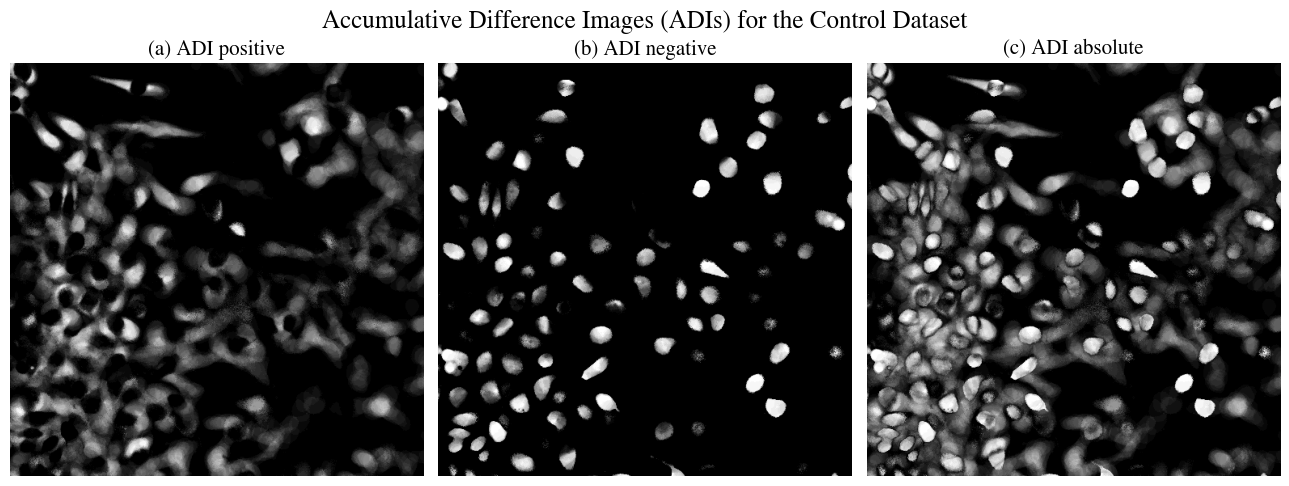

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(13, 5))
axs[0].imshow(adi_pos, cmap='grey')
axs[0].set_title('(a) ADI positive', fontname='STIXGeneral', fontsize=15)
axs[1].imshow(adi_neg, cmap='grey')
axs[1].set_title('(b) ADI negative', fontname='STIXGeneral', fontsize=15)
axs[2].imshow(adi_pos + adi_neg, cmap='grey')
axs[2].set_title('(c) ADI absolute', fontname='STIXGeneral', fontsize=15)

[axs[i].axis('off') for i in range(3)]
fig.suptitle('Accumulative Difference Images (ADIs) for the Control Dataset', fontname='STIXGeneral', fontsize=18)
plt.tight_layout()
plt.savefig('figures/adis.png')

## Cell selection

In [9]:
seed = np.zeros((512, 512))
for coord in initial_coords:
    seed[coord[1], coord[0]] = 1
seed = dip.FixedThreshold(seed, 0.5)
masked = dip.BinaryPropagation(seed, segmented[0])
labeled = dip.Label(masked, connectivity=1)
msr = dip.MeasurementTool.Measure(labeled, images['ctrl'][0], ['Gravity'])
cells = {i+1: [int(msr[i+1]['Gravity'][0]), int(msr[i+1]['Gravity'][1])] for i in range(msr.NumberOfObjects())}
labeled[labeled > 0] = 1

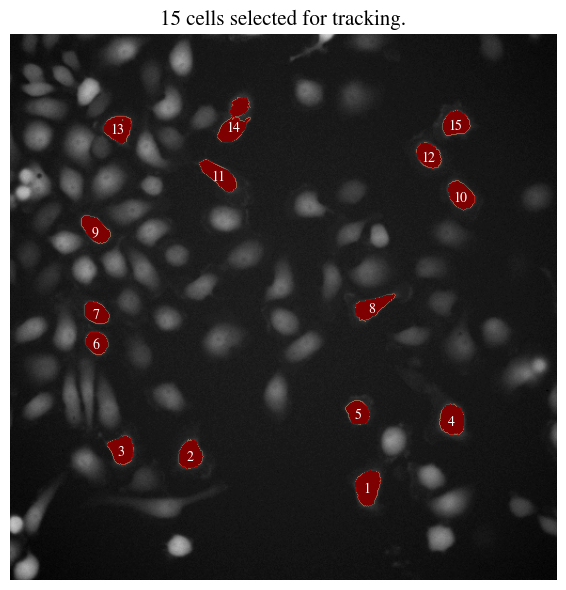

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(images['ctrl'][0], cmap='grey')
ax.imshow(labeled, alpha=1.0*(labeled>0), cmap='OrRd', origin='lower')
ax.axis('off')
ax.set_title('15 cells selected for tracking.', fontname='STIXGeneral', fontsize=15)
for k in cells.keys():
    annot_offset = 3
    if k > 9:
        annot_offset = 6
    ax.annotate(text=k, xy=(cells[k][0] - annot_offset, cells[k][1] - 5), c='w', fontname='STIXGeneral', fontsize=10)
plt.tight_layout()
plt.savefig('figures/selected_cells.png')

## Cell tracking

In [146]:
tracked_cells = {}
for i in range(len(initial_coords)):
    c = np.random.randint(len(initial_coords))
    labeled_archive, x_coords, y_coords, sizes = track_cell(images['ctrl'], segmented, initial_coords[c])
    tracked_cells[i] = {
        'labeled': labeled_archive,
        'x_coords': x_coords,
        'y_coords': y_coords,
        'sizes': sizes
    }

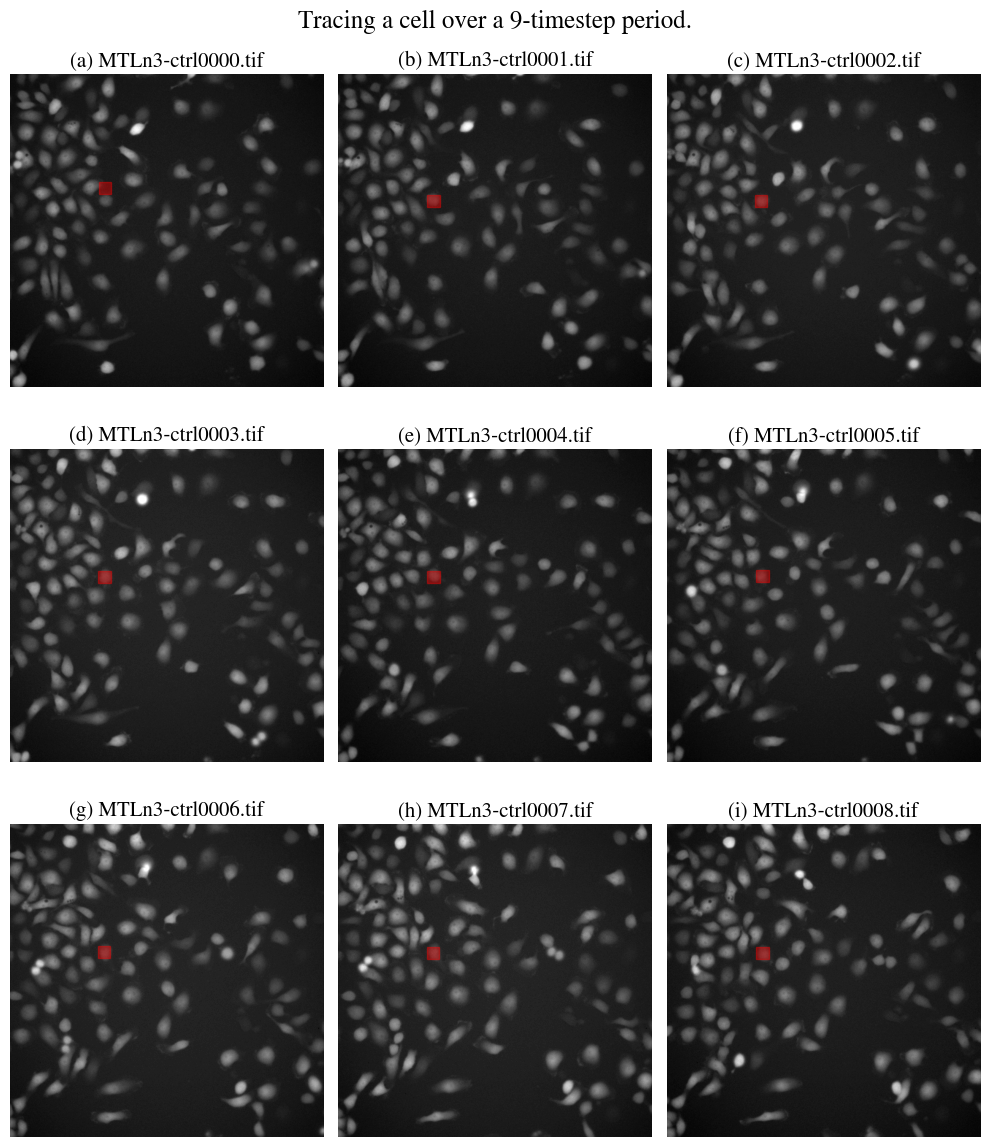

In [12]:
subcaps = string.ascii_lowercase[:9]
fig, axs = plt.subplots(3, 3, figsize=(10, 12))
axs = axs.flatten()
x_coords = tracked_cells[1]['x_coords']
y_coords = tracked_cells[1]['y_coords']
for i in range(len(axs)):
    axs[i].imshow(images['ctrl'][i], origin='lower', cmap='grey')
    rect = Rectangle(xy=(y_coords[i] - 10, x_coords[i] - 10), width=20, height=20, color='r', alpha=0.4)
    axs[i].add_patch(rect)
    axs[i].axis('off')
    num = i if i > 9 else f'0{i}'
    axs[i].set_title(f'({subcaps[i]}) MTLn3-ctrl00{num}.tif', fontname='STIXGeneral', fontsize=15)

fig.suptitle('Tracing a cell over a 9-timestep period.', fontname='STIXGeneral', fontsize=18)
plt.tight_layout()
plt.savefig('figures/single_cell_trace.png')

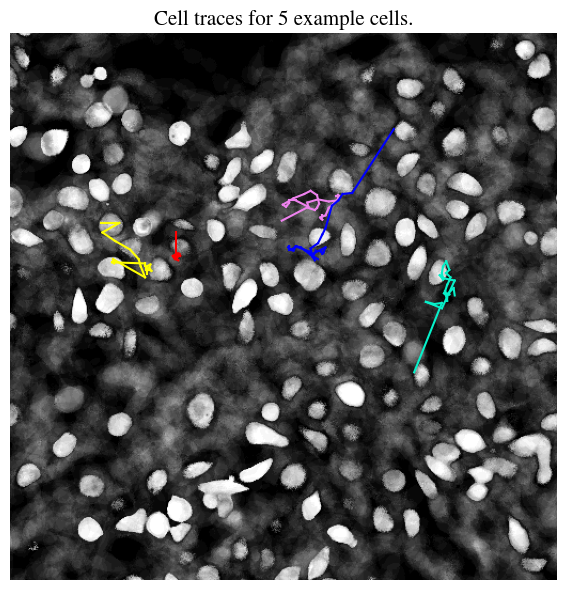

In [180]:
colors = ['r', 'violet', 'b', 'yellow', '#07f0c9']
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(adi_pos+adi_neg, origin='lower', cmap='grey')
for i in range(5):
    x_coords = tracked_cells[i]['x_coords']
    y_coords = tracked_cells[i]['y_coords']
    for j in range(len(x_coords) - 1):
        ax.plot([y_coords[j], y_coords[j+1]], [x_coords[j], x_coords[j+1]], c=colors[i])
ax.axis('off')
ax.set_title('Cell traces for 5 example cells.', fontsize=15)
plt.tight_layout()
plt.savefig('figures/cell_tracking.png')

## Tracking the experimental series (EGF+)

In [14]:
segmented_egf = {}
for num in images['egf'].keys():
    img = images['egf'][num]
    bin_img = dip.IsodataThreshold(img) # apply ISODATA threshold
    noe_img = remove_border_objects(bin_img)
    segmented_egf[num] = noe_img

In [15]:
labeled_cells = dip.Label(segmented_egf[0], connectivity=1, minSize=100, maxSize=600)
msr = dip.MeasurementTool.Measure(labeled_cells, images['egf'][0], ['Gravity', 'Size'])
coords = np.array([msr['Gravity'][i+1] for i in range(msr.NumberOfObjects())]).astype(int)

In [16]:
tracked_cells_egf = {}
for i in trange(len(coords)):
    labeled_archive, x_coords, y_coords, sizes = track_cell(images['egf'], segmented_egf, coords[i])
    tracked_cells_egf[i] = {
        'labeled': labeled_archive,
        'x_coords': x_coords,
        'y_coords': y_coords,
        'sizes': sizes
    }

100%|██████████| 103/103 [00:23<00:00,  4.45it/s]


In [17]:
R = images['egf'][0]
adi_pos = np.zeros((512, 512))
adi_neg = np.zeros((512, 512))

for i in range(30):
    grad = images['egf'][i] - R
    grad_pos, grad_neg = np.copy(grad), np.copy(grad)
    grad_pos[grad_pos > 0.01] = 1
    grad_pos[grad_pos <= 0.01] = 0
    grad_neg[grad_neg >= -0.01] = 0
    grad_neg[grad_neg < -0.01] = 1
    adi_pos += grad_pos
    adi_neg += grad_neg

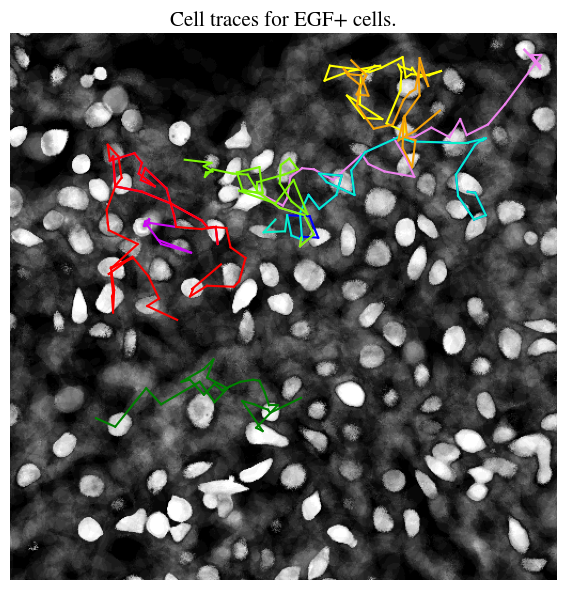

In [18]:
colors = ['r', 'violet', 'b', 'yellow', '#07f0c9', '#7ef507', 'g', '#cd07f5', '#f5a207']
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(adi_neg+adi_pos, origin='lower', cmap='grey')
for t in range(10):
    i = np.random.randint(len(tracked_cells_egf.keys()))
    x_coords = tracked_cells_egf[i]['x_coords']
    y_coords = tracked_cells_egf[i]['y_coords']
    for j in range(len(x_coords) - 1):
        ax.plot([y_coords[j], y_coords[j+1]], [x_coords[j], x_coords[j+1]], c=colors[t%len(colors)])
ax.axis('off')
ax.set_title('Cell traces for EGF+ cells.', fontname='STIXGeneral', fontsize=15)
plt.tight_layout()
plt.savefig('figures/cell_tracking_egf.png')

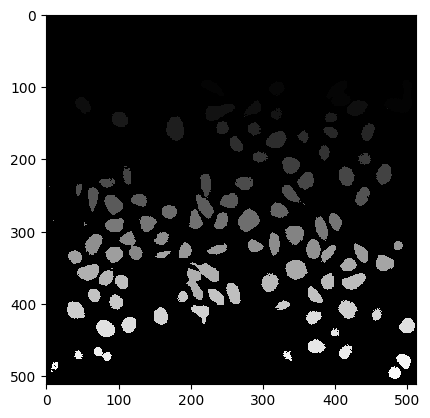

In [25]:
tracked_cells_egf[0]['labeled'][0].Show()

In [98]:
cells_data = {
    i: {'perimeter': [], 'size': [], 'area':[], 'roundness': [], 'coords': []} for i in tracked_cells_egf.keys()
}
for cell_id in tracked_cells_egf.keys():
    for timestep in range(len(tracked_cells_egf[cell_id]['labeled'])):
        msr = dip.MeasurementTool.Measure(tracked_cells_egf[cell_id]['labeled'][timestep],
                                          images['egf'][0],
                                          ['Gravity', 'Size', 'Roundness', 'SolidArea', 'Perimeter'])
        current_cell = np.array([tracked_cells_egf[cell_id]['x_coords'][timestep+1], tracked_cells_egf[cell_id]['y_coords'][timestep+1]])
        coords = np.array([msr['Gravity'][j+1] for j in range(msr.NumberOfObjects())])
        cell = np.argmin(np.sum(np.power(coords - current_cell, 2), axis=1)) + 1
        cells_data[cell_id]['perimeter'].append(msr[cell]['Perimeter'][0])
        cells_data[cell_id]['size'].append(msr[cell]['Size'][0])
        cells_data[cell_id]['area'].append(msr[cell]['SolidArea'][0])
        cells_data[cell_id]['roundness'].append(msr[cell]['Roundness'][0])
        cells_data[cell_id]['coords'].append(msr[cell]['Gravity'][0])

In [148]:
cells_data_ctrl = {
    i: {'perimeter': [], 'size': [], 'area':[], 'roundness': [], 'coords': []} for i in tracked_cells.keys()
}
for cell_id in tracked_cells.keys():
    for timestep in range(len(tracked_cells[cell_id]['labeled'])):
        msr = dip.MeasurementTool.Measure(tracked_cells[cell_id]['labeled'][timestep],
                                          images['egf'][0],
                                          ['Gravity', 'Size', 'Roundness', 'SolidArea', 'Perimeter'])
        current_cell = np.array([tracked_cells[cell_id]['x_coords'][timestep+1], tracked_cells[cell_id]['y_coords'][timestep+1]])
        coords = np.array([msr['Gravity'][j+1] for j in range(msr.NumberOfObjects())])
        cell = np.argmin(np.sum(np.power(coords - current_cell, 2), axis=1)) + 1
        cells_data_ctrl[cell_id]['perimeter'].append(msr[cell]['Perimeter'][0])
        cells_data_ctrl[cell_id]['size'].append(msr[cell]['Size'][0])
        cells_data_ctrl[cell_id]['area'].append(msr[cell]['SolidArea'][0])
        cells_data_ctrl[cell_id]['roundness'].append(msr[cell]['Roundness'][0])
        cells_data_ctrl[cell_id]['coords'].append(msr[cell]['Gravity'][0])

In [242]:
p_names = ('perimeter', 'size', 'area', 'roundness')
parameters = {'ctrl': {p: {'mean': [], 'max': [], 'min': []} for p in p_names},
              'egf': {p: {'mean': [], 'max': [], 'min': []} for p in p_names}}

for p in p_names:
    vals = {'ctrl': [], 'egf': []}
    for i in cells_data.keys():
        vals['egf'].append(cells_data[i][p])
    for i in cells_data_ctrl.keys():
        vals['ctrl'].append(cells_data_ctrl[i][p])

    sizes = {k: np.array(vals[k]) for k in vals.keys()}
    means_ctrl = np.mean(vals['ctrl'], axis=0)
    mins_ctrl = np.min(vals['ctrl'], axis=0)
    maxs_ctrl = np.max(vals['ctrl'], axis=0)
    means = np.mean(vals['egf'], axis=0)
    mins = np.min(vals['egf'], axis=0)
    maxs = np.max(vals['egf'], axis=0)
    parameters['ctrl'][p]['mean'] = means_ctrl
    parameters['ctrl'][p]['min'] = mins_ctrl
    parameters['ctrl'][p]['max'] = maxs_ctrl
    parameters['egf'][p]['mean'] = means
    parameters['egf'][p]['min'] = mins
    parameters['egf'][p]['max'] = maxs

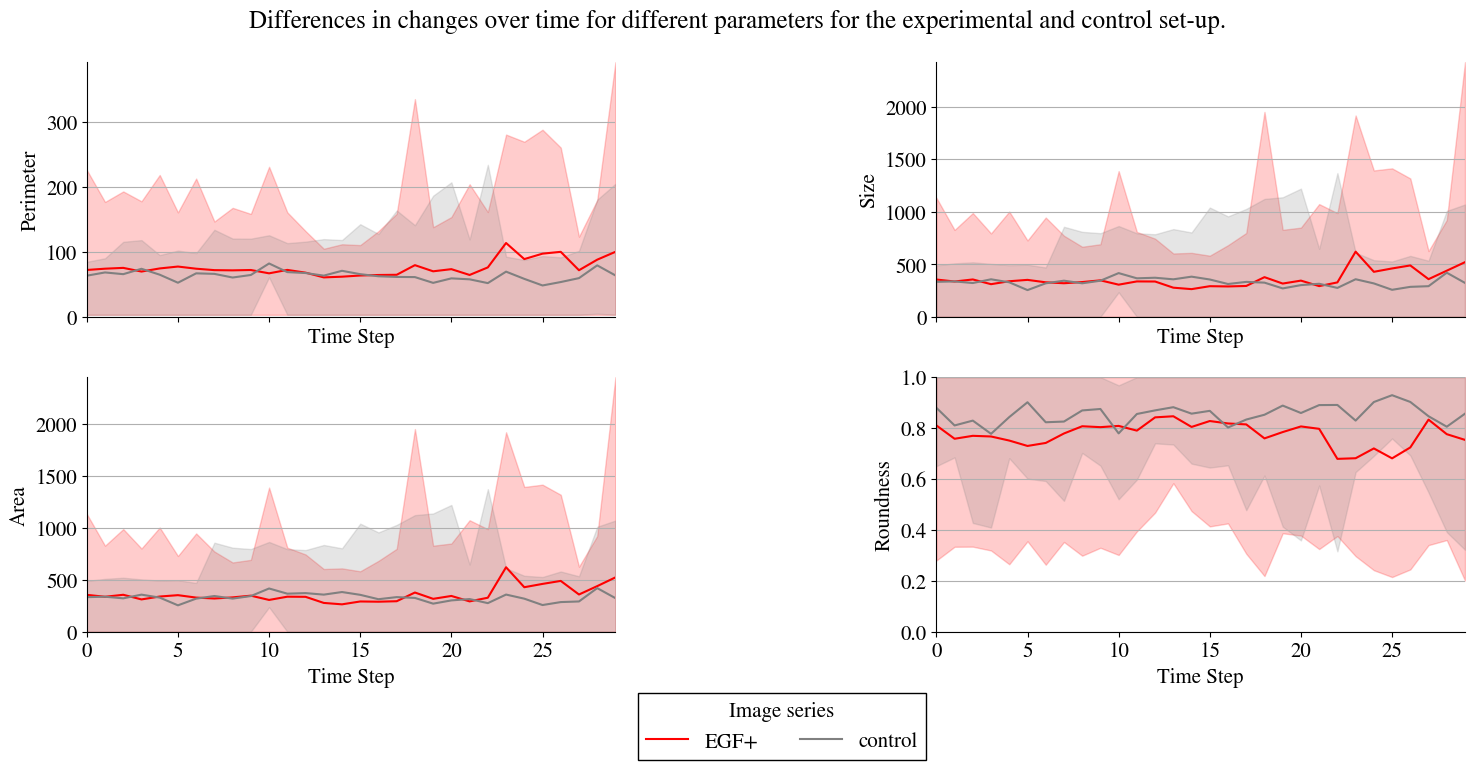

In [321]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8), sharex=True)
cs = ['r', 'grey']
axs = axs.flatten()
for idx, p in enumerate(p_names):
    axs[idx].plot(np.arange(30), parameters['egf'][p]['mean'], color=cs[0], label='EGF+')
    axs[idx].fill_between(np.arange(30), parameters['egf'][p]['min'], parameters['egf'][p]['max'], alpha=0.2, color=cs[0])
    axs[idx].plot(np.arange(30), parameters['ctrl'][p]['mean'], color=cs[1], label='control')
    axs[idx].fill_between(np.arange(30), parameters['ctrl'][p]['min'], parameters['ctrl'][p]['max'], alpha=0.2, color=cs[1])
    axs[idx].spines[['right', 'top']].set_visible(False)
    axs[idx].set_xlim(xmin=0, xmax=29)
    axs[idx].set_ylim(ymin=0, ymax=np.max([parameters['egf'][p]['max'].max(), parameters['ctrl'][p]['max'].max()]))
    axs[idx].grid(axis='y', zorder=0)
    # axs[0].legend(title='Image series', alignment='left', bbox_to_anchor=(0.2, 0.98), frameon=True, ncol=1,
    #           edgecolor='k', facecolor='w', framealpha=1, fancybox=False)
    # axs[idx].set_title('Change of cells area over time for different experimental conditions.')
    axs[idx].set_xlabel('Time Step')
    axs[idx].set_ylabel(f'{p.title()}')

plt.legend(title='Image series', alignment='center', bbox_to_anchor=(0, -0.2), frameon=True, ncol=2,
           edgecolor='k', facecolor='w', framealpha=1, fancybox=False)
plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle('Differences in changes over time for different parameters for the experimental and control set-up.')

plt.tight_layout()
plt.savefig('figures/parameter_change.png')

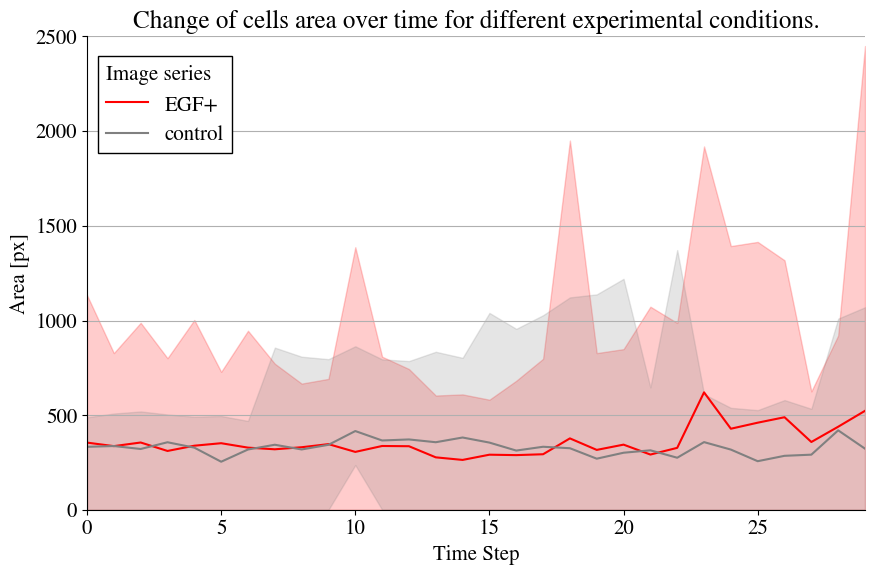

In [230]:
fig, ax = plt.subplots(2, 2, figsize=(9, 6))
cs = ['#0d7cb8', 'g']
cs = ['r', 'grey']
ax.plot(np.arange(30), means, color=cs[0], label='EGF+')
ax.fill_between(np.arange(30), mins, maxs, alpha=0.2, color=cs[0])
ax.plot(np.arange(30), means_ctrl, color=cs[1], label='control')
ax.fill_between(np.arange(30), mins_ctrl, maxs_ctrl, alpha=0.2, color=cs[1])
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim(xmin=0, xmax=29)
ax.set_ylim(ymin=0, ymax=2500)
ax.grid(axis='y', zorder=0)
ax.legend(title='Image series', alignment='left', bbox_to_anchor=(0.2, 0.98), frameon=True, ncol=1,
          edgecolor='k', facecolor='w', framealpha=1, fancybox=False)
ax.set_title('Change of cells area over time for different experimental conditions.')
ax.set_xlabel('Time Step')
ax.set_ylabel('Area [px]')
plt.tight_layout()
plt.savefig('figures/size_change.png')

In [92]:
msr = dip.MeasurementTool.Measure(tracked_cells_egf[1]['labeled'][2],
                                    images['egf'][0],
                                    ['Gravity', 'Size', 'Roundness', 'SolidArea', 'Perimeter'])

In [93]:
print(msr)

  |                 Gravity |       Size |  Roundness |  SolidArea |  Perimeter | 
- | ----------------------- | ---------- | ---------- | ---------- | ---------- | 
  |       dim0 |       dim1 |            |            |            |            | 
  |       (px) |       (px) |      (px²) |            |      (px²) |       (px) | 
- | ---------- | ---------- | ---------- | ---------- | ---------- | ---------- | 
1 |      51.00 |      230.0 |      1.000 |      1.000 |      1.000 |      3.142 | 
2 |      58.49 |      242.9 |      461.0 |     0.6823 |      461.0 |      92.15 | 
3 |      57.40 |      259.5 |      135.0 |     0.7125 |      136.0 |      48.98 | 
4 |      45.00 |      258.0 |      1.000 |      1.000 |      1.000 |      3.142 | 



In [90]:
tracked_cells_egf[1]['x_coords'][:10]

[214, 242, 251, 259, 258, 258, 258, 257, 258, 251]

In [91]:
tracked_cells_egf[1]['y_coords'][:10]


[28, 44, 40, 57, 64, 66, 64, 57, 38, 41]

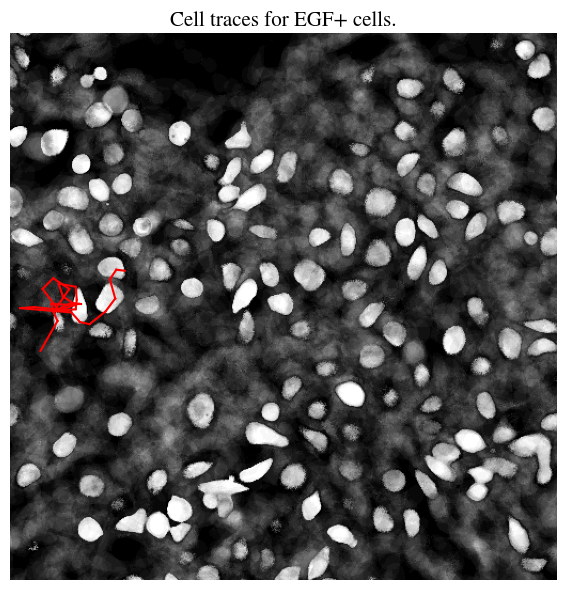

In [44]:
colors = ['r', 'violet', 'b', 'yellow', '#07f0c9', '#7ef507', 'g', '#cd07f5', '#f5a207']
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(adi_neg+adi_pos, origin='lower', cmap='grey')
x_coords = tracked_cells_egf[1]['x_coords']
y_coords = tracked_cells_egf[1]['y_coords']
for j in range(len(x_coords) - 1):
    ax.plot([y_coords[j], y_coords[j+1]], [x_coords[j], x_coords[j+1]], c=colors[0])
    
ax.axis('off')
ax.set_title('Cell traces for EGF+ cells.', fontname='STIXGeneral', fontsize=15)
plt.tight_layout()
plt.savefig('figures/cell_tracking_egf.png')